2. Viết chương gán nhãn ảnh <br>
2.1 Gán nhãn ảnh <br>


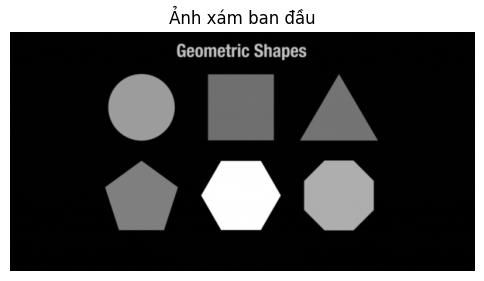

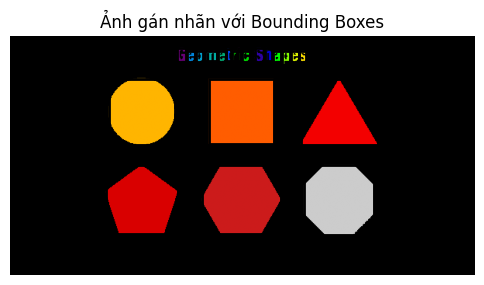

In [7]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# đọc ảnh và chuyển sang ảnh xám
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)

# hiển thị ảnh xám ban đầu
plt.figure(figsize=(6, 6))
plt.imshow(a, cmap='gray')
plt.title('Ảnh xám ban đầu')
plt.axis('off')
plt.show()

# thực hiện ngưỡng Otsu
thres = threshold_otsu(a)

# giữ lại các pixel có cường độ lớn hơn ngưỡng
b = a > thres

# thực hiện gán nhãn cho ảnh nhị phân b
c = label(b)

# lưu ảnh gán nhãn dưới dạng PNG (vì JPEG không hỗ trợ mode 'I')
iio.imsave('label_output.png', c.astype(np.uint16))

# thực hiện regionprops trên ảnh đã gán nhãn c
properties = ['Area', 'Centroid', 'BoundingBox']
d = regionprops(c)

# dòng lệnh sau tạo một biểu đồ rỗng có kích thước 6 inch x 6 inch
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(c, cmap='nipy_spectral')  # hoặc cmap='YlOrRd' tùy chọn

for i in d:
    lr, lc, ur, uc = i['BoundingBox']
    rec_width = uc - lc
    rec_height = ur - lr
    # Vẽ các khung chữ nhật với gốc tại (lr, lc)
    rect = mpatches.Rectangle((lc, lr), rec_width, rec_height, fill=False,
                              edgecolor='black', linewidth=2)
    ax.add_patch(rect)

plt.title('Ảnh gán nhãn với Bounding Boxes')
plt.axis('off')
plt.show()


2.2 Dò tìm cạnh theo chiều dọc

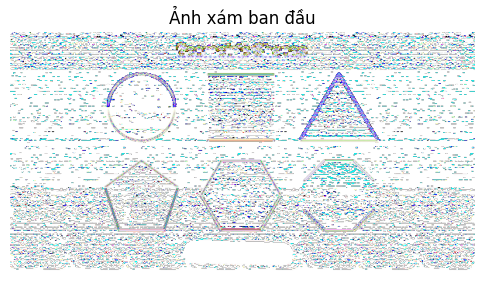

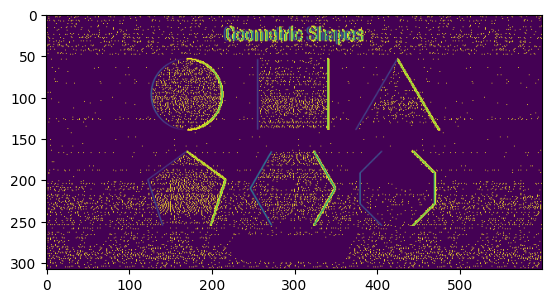

In [16]:
from PIL import Image
import cv2
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

data = Image.open('geometric.png').convert('L')

plt.figure(figsize=(6, 6))
plt.imshow(a, cmap='gray')
plt.title('Ảnh xám ban đầu')
plt.axis('off')
plt.show()

bmg = abs(data - nd.shift(data, (0,1), order=0))
plt.imshow(bmg)
plt.show()

2.3 Dò tìm cạnh với Sobel Filter

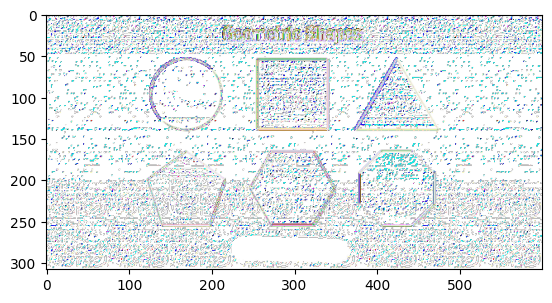

In [15]:
from PIL import Image
import cv2
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

data = Image.open('geometric.png')

a = nd.sobel(data, axis=0)
b = nd.sobel(data, axis=1)

bmg = abs(a) + abs(b)
plt.imshow(bmg)
plt.show()

2.4 Xác định góc của đối tượng

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-49.800000000000004..255.0].


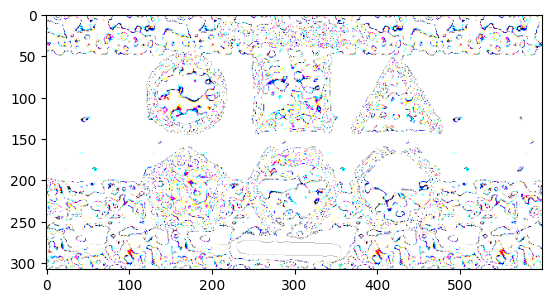

In [ ]:
from PIL import Image
import cv2
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

def Harris(indata, alpha=0.2):
    x = nd.sobel(indata, 0)
    y = nd.sobel(indata, 1)
    
    x1 = x**2
    y1 = y**2
    xy = abs(x*y)
    x1 = nd.gaussian_filter(x1,3)
    y1 = nd.gaussian_filter(y1,3)
    xy = nd.gaussian_filter(xy,3)

    detC = x1 * y1 - 2 * xy
    trC = x1 * y1
    R = detC - alpha * trC**2
    trC = x1+y1
    R = detC- alpha * trC**2
    return R

data = Image.open('geometric.png')
bmg = Harris(data)
plt.imshow(bmg)
plt.show()


2.5 Dò tìm hình dạng cụ thể trong ảnh với Hough Transform <br>
2.5.1 Dò tìm đường thẳng trong ảnh

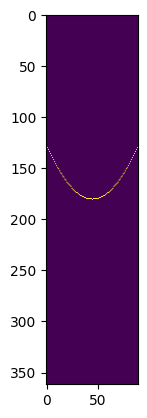

In [14]:
from PIL import Image
import cv2
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

def LineHough(data, gamma):
    V, H = data.shape
    R = int(np.sqrt(V*V + H*H))
    ho = np.zeros((R,90), float) #Hough space

    w = data + 0
    ok = 1
    theta = np.arange(90)/180 * np.pi
    tp = np.arange(90).astype(float)
    while ok:
        mx = w.max()
        if mx<gamma:
            ok=0
        else:
            v,h = divmod(w.argmax(), H)
            y = V - v
            x = h
            rh = x * np.cos(theta) + y * np.sin(theta)
            for i in range(len(rh)):
                if 0 <= rh[i] < R and 0 <= tp[i] < 90:
                    ho[int(rh[i]), int(tp[i])] += mx
            w[v,h] = 0
    return ho

data = np.zeros((256,256))
data[128,128] = 1
bmg = LineHough(data, 0.5)
plt.imshow(bmg)
plt.show()

2.5.2 Dò tìm đường tròn trong ảnh

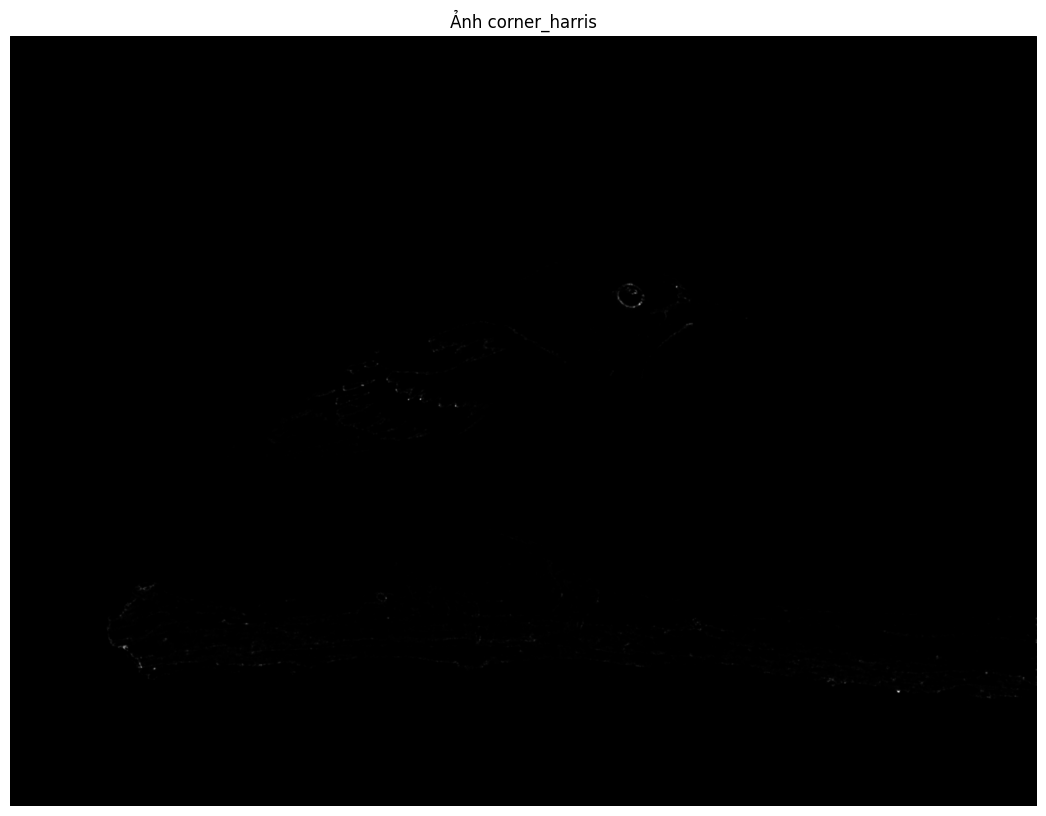

In [18]:
from PIL import Image
import cv2
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.feature import corner_harris
from skimage.color import rgb2gray 

# đọc ảnh
data = iio.imread('bird.png')

# chuyển ảnh RGB sang ảnh xám (float trong khoảng [0,1])
image_gray = rgb2gray(data)

# phát hiện góc bằng corner_harris với hệ số k=0.001
coordinate = corner_harris(image_gray, k=0.001)

# hiển thị kết quả
plt.figure(figsize=(20, 10))
plt.imshow(coordinate, cmap='gray')  # thêm cmap để hiển thị ảnh xám rõ ràng hơn
plt.axis('off')
plt.title('Ảnh corner_harris')
plt.show()


Thực hành 07 <br>
2.6 Image Matching

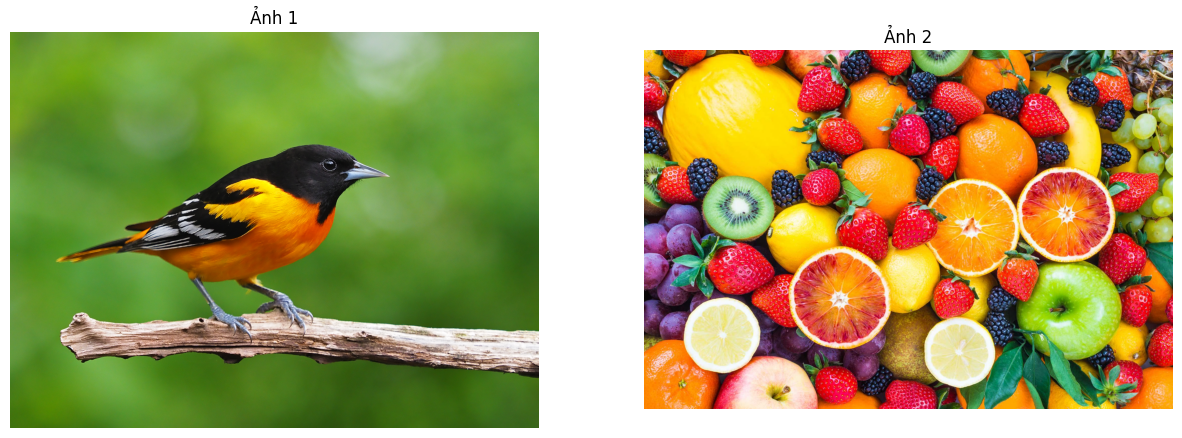

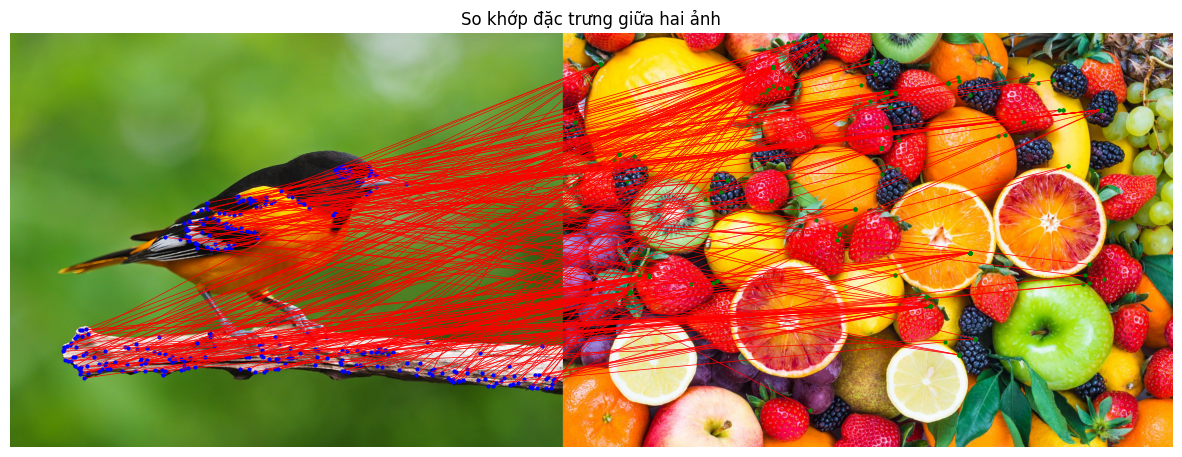

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.feature import corner_harris, corner_peaks
from skimage.util import view_as_windows
from skimage.transform import resize
from sklearn.metrics.pairwise import euclidean_distances

def extract_descriptors(image_gray, keypoints, patch_size=11):
    descriptors = []
    valid_points = []
    half = patch_size // 2


    padded = np.pad(image_gray, ((half, half), (half, half)), mode='reflect')

    for (y, x) in keypoints:
        patch = padded[y:y+patch_size, x:x+patch_size]
        if patch.shape == (patch_size, patch_size):
            descriptors.append(patch.flatten())
            valid_points.append((y, x))

    return np.array(descriptors), np.array(valid_points)


img1 = io.imread('bird.png')
img2 = io.imread('fruit.jpg')

gray1 = color.rgb2gray(img1)
gray2 = color.rgb2gray(img2)


kp1 = corner_peaks(corner_harris(gray1), min_distance=5)[:300]
kp2 = corner_peaks(corner_harris(gray2), min_distance=5)[:300]


des1, pts1 = extract_descriptors(gray1, kp1, patch_size=11)
des2, pts2 = extract_descriptors(gray2, kp2, patch_size=11)


dist = euclidean_distances(des1, des2)
matches = np.argmin(dist, axis=1)


fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(img1)
ax[0].set_title('Ảnh 1')
ax[0].axis('off')
ax[1].imshow(img2)
ax[1].set_title('Ảnh 2')
ax[1].axis('off')


if img1.shape[0] != img2.shape[0]:
    h1 = img1.shape[0]
    scale = h1 / img2.shape[0]
    new_width = int(img2.shape[1] * scale)
    img2 = resize(img2, (h1, new_width), preserve_range=True).astype(img1.dtype)


combined = np.hstack((img1, img2))


fig, ax_all = plt.subplots(figsize=(15, 10))
ax_all.imshow(combined.astype(np.uint8))
ax_all.axis('off')
ax_all.set_title('So khớp đặc trưng giữa hai ảnh')

offset_x = img1.shape[1]
for i, m in enumerate(matches):
    y1, x1 = pts1[i]
    y2, x2 = pts2[m]
    ax_all.plot([x1, x2 + offset_x], [y1, y2], 'r-', linewidth=0.5)
    ax_all.plot(x1, y1, 'bo', markersize=2)
    ax_all.plot(x2 + offset_x, y2, 'go', markersize=2)

plt.show()
